In [1]:
import tensorflow as tf
import numpy as np
import vgg19
import matplotlib.pyplot as plt
import utils

In [2]:
#img = tf.placeholder(tf.float32, [None, 224, 224, 3])
i_max = 1000
i_print = 100

#noise_center - noise_weight , noise_center + noise_weight
noise_min = 0.1
noise_max = 0.5

device = '/gpu:0'
show = True

#layers = [vgg.pool4, vgg.pool3, vgg.pool2, vgg.pool1, vgg.conv1_1]
style_weight = [0.3, 0.8, 0.9, 1.0, 1.0]
gram_weight = 1.0
histogram_weight = 5.0

In [3]:
def gram_matrix(F, N, M):
    Ft = tf.reshape(F, (M, N))
    if M < N:
        return tf.matmul(Ft,tf.transpose(Ft))
    else:
        return tf.matmul(tf.transpose(Ft), Ft)

In [4]:
def create_noise_image(width, height, noise_min = 0.0, noise_max = 1.0):
    image = np.random.uniform(noise_min,noise_max, (1, height, width, 3)).astype('float32')
    
    if(show == True):
        plt.imshow(image.reshape(height,width,3))
        plt.show()
    return image

In [5]:
def get_image(path):
    #load image
    img_input = utils.load_image(path)
    img = img_input.reshape((1, 224, 224, 3))
    
    #show image
    if(show == True):
        plt.imshow(img_input.reshape((224,224,3)))
        plt.show()
        
    return img

In [6]:
def get_layers(vgg, image, scope):   
    
    with tf.name_scope(scope):
        vgg.build(image)

    layers = [vgg.pool4, vgg.pool3, vgg.pool2, vgg.pool1, vgg.conv1_1]
    #layers = [vgg.conv1_1]
    
    return layers

In [7]:
def get_gram_loss(target_layers, input_layers):
    gram_losses = []
    #go through layers
    for tl, il, w in zip(target_layers, input_layers, style_weight):
        #get dimensions
        dimensions = tl.get_shape().as_list()
        size = dimensions[3]*dimensions[2]*dimensions[1]
        
        #get gram
        target_gram = gram_matrix(tl, dimensions[3], dimensions[2]*dimensions[1])
        input_gram = gram_matrix(il, dimensions[3], dimensions[2]*dimensions[1])
        #gram_losses.append(tf.nn.l2_loss(target_gram))
        #gram_losses.append(tf.nn.l2_loss(input_gram))
        
        #get losses
        gram_losses.append(gram_weight * w * tf.log(tf.reduce_sum(tf.square(target_gram - input_gram)) / size ))
    
    #get gram_loss
    gram_loss = tf.reduce_sum(gram_losses)
    
    return gram_losses

In [8]:
def get_histogram_loss(target_layers, input_layers):
    histogram_losses = []
    #go through layers
    for tl, il, w in zip(target_layers, input_layers, style_weight):
        #get dimensions
        dimensions = tl.get_shape().as_list()
        size = dimensions[3]*dimensions[2]*dimensions[1]
        
        #get histogram
        target_histogram = tf.histogram_fixed_width(tf.cast(tl,tf.float32), [0.0, 1.0], 100)
        input_histogram= tf.histogram_fixed_width(tf.cast(il,tf.float32), [0.0, 1.0], 100)
        
        #get losses
        histogram_losses.append(histogram_weight * w * tf.log(tf.reduce_sum(tf.square(target_histogram - input_histogram)) / size ))
    
    #get gram_loss
    histogram_loss = tf.reduce_sum(histogram_losses)
    
    return tf.cast(histogram_losses,tf.float32)

In [9]:
def get_loss(target_layers, input_layers):
    loss = []
    
    #gram loss
    loss.append(get_gram_loss(target_layers, input_layers))
    
    #get histogram matrices
    loss.append(get_histogram_loss(target_layers, input_layers))
    
    

    return loss

/home/rwjoverwater/in4015/vgg19.npy
npy file loaded


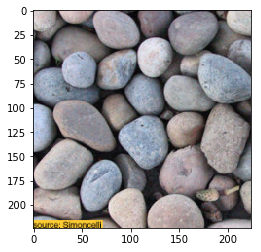

build model started
build model finished: 0s


In [10]:
#create style data from style image
with tf.device('/cpu:0'):
    sess = tf.Session()
    
    #create style vgg()
    vgg = vgg19.Vgg19()
    
    #load style image
    input_img = get_image("./test_data/pebbles.jpg")  

    #input vgg
    input_image = tf.constant(input_img, tf.float32)
    
    #layers
    layers = sess.run(get_layers(vgg, input_image, "style"))
    
    #loop through layers and assign to style layers
    style_layers = [tf.constant(layers[0]), tf.constant(layers[1]), tf.constant(layers[2]),
                    tf.constant(layers[3]), tf.constant(layers[4])]
    
    #sess.close()

/home/rwjoverwater/in4015/vgg19.npy
npy file loaded


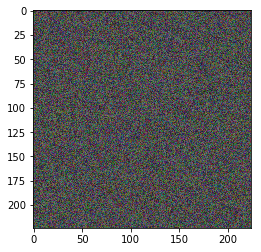

build model started
build model finished: 0s


In [11]:
    #create computational graph for target
    #with tf.device(device):
    #sess = tf.Session()
    #create vgg  
    vgg = vgg19.Vgg19()
        
    #placeholders
    #input_image = tf.placeholder(tf.float32, [1, 224, 224, 3])
    
    #load style image
    #input_img = get_image("./test_data/fire.jpg")
    #create target image
    target = tf.Variable((create_noise_image(224, 224, noise_min, noise_max)), tf.float32)
    #fill feed dictionary
    #feed = {input_image: input_img}
                 
    #create variables                 
    
    #target vgg
    target_layers = get_layers(vgg, target, "target")


In [12]:
    #input vgg
    #style_layers = sess.run(get_layers(vgg, input_image, "style"), feed)
    
    #get losses
    loss = get_loss(target_layers, style_layers)

In [13]:
    
    #handlers
    optimizer = tf.train.GradientDescentOptimizer(1.0)
    minimize = optimizer.minimize(tf.reduce_sum(loss))
    
    #init
    sess.run(tf.global_variables_initializer())
    
    
    print(sess.run(loss))
    print(sess.run(get_loss(target_layers, style_layers)))
    

[[10.039601, 32.11932, 31.580832, 33.042027, 28.137449], array([ 12.47393417,          nan,  33.5735054 ,  31.38254547,          nan], dtype=float32)]
[[10.039601, 32.11932, 31.580832, 33.042027, 28.137449], array([ 12.47393417,          nan,  33.5735054 ,  31.38254547,          nan], dtype=float32)]


10.0%  20.0%  30.0%  40.0%  50.0%  60.0%  70.0%  80.0%  90.0%  0.0%  
1
[[9.5239439, 28.098692, 27.51446, 32.044044, 27.401791], array([  8.72422314,  17.02744484,  14.48125553,  34.39830399,  31.35078812], dtype=float32)]


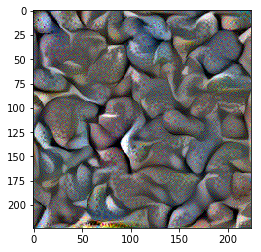

10.0%  20.0%  30.0%  40.0%  50.0%  60.0%  70.0%  80.0%  90.0%  0.0%  
2
[[9.5306549, 28.174391, 27.188417, 31.884855, 27.258186], array([  8.58546162,  14.56193542,  16.85939026,  33.96615219,  24.98444176], dtype=float32)]


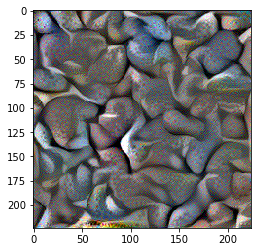

10.0%  20.0%  30.0%  40.0%  50.0%  60.0%  70.0%  80.0%  90.0%  0.0%  
3
[[9.538003, 28.217138, 26.929304, 31.688791, 27.081118], array([  8.52904415,  13.09766006,  18.29094887,  33.59243011,          nan], dtype=float32)]


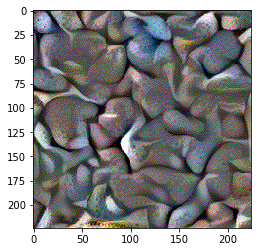

10.0%  20.0%  30.0%  40.0%  50.0%  60.0%  70.0%  80.0%  90.0%  0.0%  
4
[[9.5240631, 27.445929, 26.629623, 31.401371, 26.847387], array([  8.65021896,  17.09492683,  19.92674255,  33.40927505,          nan], dtype=float32)]


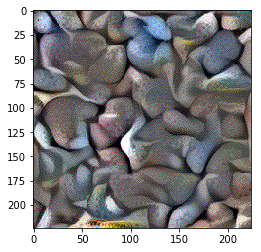

10.0%  20.0%  30.0%  40.0%  50.0%  60.0%  70.0%  80.0%  90.0%  0.0%  
5
[[9.5404997, 28.063215, 26.711649, 31.071375, 26.533766], array([  8.40399265,   9.04755402,  21.27125931,  33.50482178,  30.85532188], dtype=float32)]


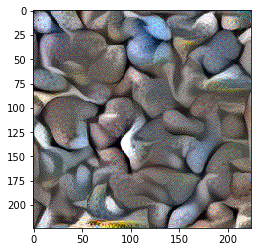

10.0%  20.0%  30.0%  40.0%  50.0%  60.0%  70.0%  80.0%  90.0%  0.0%  
6
[[9.5419035, 28.300541, 26.740456, 30.475708, 26.009043], array([  8.54732323,   8.53442764,  20.34545898,  33.57081985,  27.74065971], dtype=float32)]


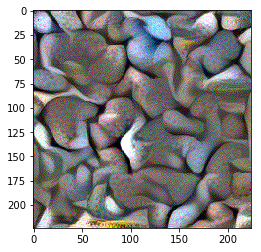

10.0%  20.0%  30.0%  40.0%  50.0%  60.0%  70.0%  80.0%  90.0%  0.0%  
7
[[9.5414982, 27.911299, 26.726711, 28.981503, 24.690672], array([  8.55042267,  12.80262566,  20.59273529,  34.03763199,  21.65420532], dtype=float32)]


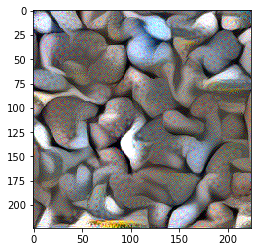

10.0%  20.0%  30.0%  40.0%  50.0%  60.0%  70.0%  80.0%  90.0%  0.0%  
8
[[9.5809784, 29.19664, 27.832972, 28.421284, 23.176863], array([  8.49570656,  -6.32077646,  19.40843964,  34.85078049,  22.87219048], dtype=float32)]


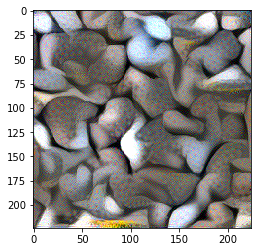

10.0%  20.0%  30.0%  40.0%  50.0%  60.0%  70.0%  80.0%  90.0%  0.0%  
9
[[9.5399733, 27.136683, 26.685776, 28.318399, 22.520859], array([  8.69778728,  12.92660427,  20.56125641,  33.46154404,  22.86339378], dtype=float32)]


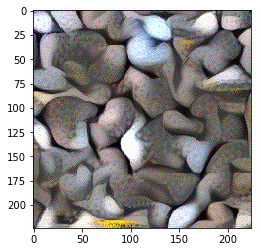

10.0%  20.0%  30.0%  40.0%  50.0%  60.0%  70.0%  80.0%  90.0%  0.0%  
10
[[9.5442858, 28.915791, 28.353586, 30.126362, 24.204557], array([  8.76956654,  14.36492157,  19.23244858,  30.58866692,  27.111166  ], dtype=float32)]


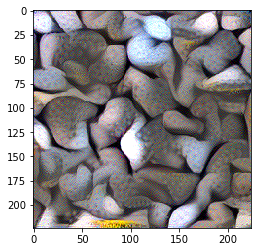

In [15]:
    for i in range(i_max):
        
        #optimize step
        sess.run(minimize)
        #clip
        target = tf.maximum(tf.minimum(target,1),0)
        
        progress = ((i+1)%i_print)/i_print*100
        if(round(progress) % 10 == 0):
            print(progress, end = '% ')
            print(' ', end = '')
        
        if((i+1) % i_print == 0):
            
            #print loss
            #print(sess.run(target_layers, feed_dict = feed))
            print('')
            print(round((i+1)/i_print))
            print(sess.run(loss))

            #show image
            if(show == True):
                plt.imshow(sess.run(tf.reshape(target,(224,224,3))))
                plt.show()

    
